# Setup & Imports

In [3]:
# 📦 Install dependencies
# Run this cell once to make sure all required packages are available

%pip install -q pandas numpy biopython matplotlib seaborn tqdm goatools plotly umap-learn scikit-learn torch transformers


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Standard libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# GO Ontology
from goatools.obo_parser import GODag


In [5]:
# Define data paths
DATA_DIR = "./cafa-6-protein-function-prediction"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")

print("Files in Train:", os.listdir(TRAIN_DIR))
print("Files in Test:", os.listdir(TEST_DIR))


Files in Train: ['train_taxonomy.tsv', 'train_terms.tsv', 'go-basic.obo', 'train_sequences.fasta']
Files in Test: ['testsuperset.fasta', 'testsuperset-taxon-list.tsv']


# 🧠 Explore Dataset Size and Structure

- Count the number of sequences in:

    - train_sequences.fasta

    - testsuperset.fasta

- Count unique proteins in train_terms.tsv and train_taxonomy.tsv

- Check if all sequence IDs match across files.

👉 Goal: Ensure internal consistency between FASTA, taxonomy, and term mapping files.

In [18]:
# Load TSV files
train_terms = pd.read_csv(os.path.join(TRAIN_DIR, "train_terms.tsv"), sep="\t")
train_taxonomy = pd.read_csv(
    os.path.join(TRAIN_DIR, "train_taxonomy.tsv"),
    sep="\t",
    header=None,
    names=["EntryID", "Taxon"]
)

IA = pd.read_csv(
    os.path.join(DATA_DIR, "IA.tsv"),
    sep="\t",
    header=None,
    names=["GO_ID", "InformationAccretion"]
)


print("train_terms:", train_terms.shape)
print("train_taxonomy:", train_taxonomy.shape)
print("IA:", IA.shape)


train_terms: (537027, 3)
train_taxonomy: (82404, 2)
IA: (40122, 2)


In [13]:
# Preview first few rows
display(train_terms.head())
display(train_taxonomy.head())
display(IA.head())


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


,EntryID,Taxon
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


,GO_ID,InformationAccretion
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573


### Count and Check Data Consistency

In [19]:
fasta_path = os.path.join(TRAIN_DIR, "train_sequences.fasta")
#  Unique protein IDs
def extract_uniprot_id(record_id):
    # e.g. "sp|Q9Y2Q0|ABC1_HUMAN" → "Q9Y2Q0"
    parts = record_id.split('|')
    if len(parts) >= 2:
        return parts[1]
    return record_id  # fallback if no pipe present

train_seq_ids = {extract_uniprot_id(record.id) for record in SeqIO.parse(fasta_path, "fasta")}
term_ids = set(train_terms['EntryID'])
tax_ids = set(train_taxonomy['EntryID'])

print(f"Sequences: {len(train_seq_ids)} | Terms: {len(term_ids)} | Taxonomy: {len(tax_ids)}")
print("Unmatched IDs (terms not in sequences):", len(term_ids - train_seq_ids))

Sequences: 82404 | Terms: 82404 | Taxonomy: 82404
Unmatched IDs (terms not in sequences): 0


### Sequence Length Distribution

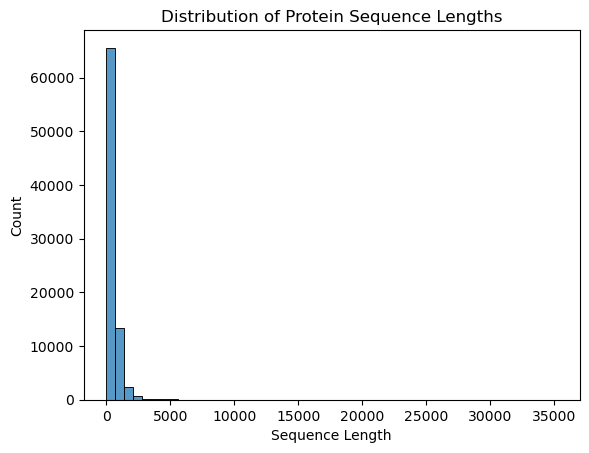

In [21]:
seq_lengths = [len(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
sns.histplot(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Protein Sequence Lengths")
plt.show()


The histogram is extremely right-skewed — most proteins have short sequences (clustered near the left), and a few are very long (creating a “long tail”).

### Plotting After Remove statistical outliers

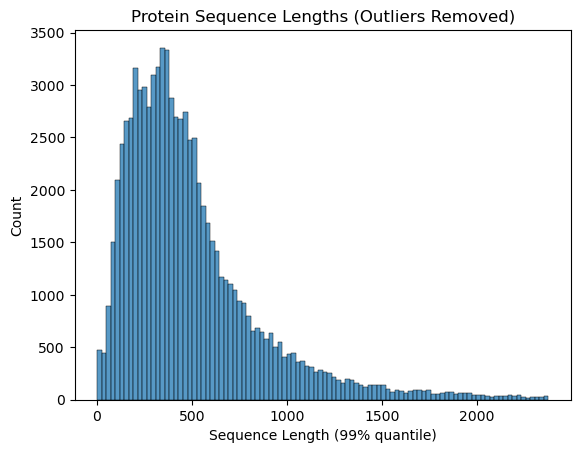

In [24]:
import numpy as np

lengths = np.array(seq_lengths)
filtered_lengths = lengths[lengths < np.percentile(lengths, 99)]  # keep 99% shortest

sns.histplot(filtered_lengths, bins=100)
plt.xlabel("Sequence Length (99% quantile)")
plt.ylabel("Count")
plt.title("Protein Sequence Lengths (Outliers Removed)")
plt.show()


### Overview for Sequence Distribution

In [27]:
print("Min length:", np.min(seq_lengths))
print("Median length:", np.median(seq_lengths))
print("Mean length:", np.mean(seq_lengths))
print("95th percentile:", np.percentile(seq_lengths, 95))
print("Max length:", np.max(seq_lengths))

Min length: 3
Median length: 409.0
Mean length: 525.7882869763604
95th percentile: 1318.0
Max length: 35213


## Number of GO Terms per Protein

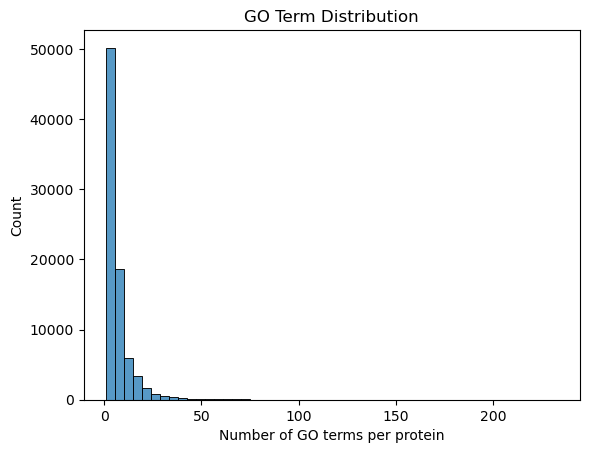

In [26]:
go_counts = train_terms.groupby('EntryID')['term'].count()
sns.histplot(go_counts, bins=50)
plt.xlabel("Number of GO terms per protein")
plt.ylabel("Count")
plt.title("GO Term Distribution")
plt.show()


In [29]:
print("Min length:", np.min(go_counts))
print("Median length:", np.median(go_counts))
print("Mean length:", np.mean(go_counts))
print("95th percentile:", np.percentile(go_counts, 95))
print("Max length:", np.max(go_counts))
# Find the protein with the highest number of GO terms
max_go_count = go_counts.max()
top_proteins = go_counts[go_counts == max_go_count]
print(f"Number of proteins with {max_go_count} GO terms: {len(top_proteins)}")
print(top_proteins)


Min length: 1
Median length: 4.0
Mean length: 6.517001601863988
95th percentile: 20.0
Max length: 233
Number of proteins with 233 GO terms: 1
EntryID
Q02248    233
Name: term, dtype: int64
